# Bayes - A Nonparametric Bayesian Approach to Modeling Overlapping Clusters

In [2]:
%matplotlib inline

In [20]:
from matplotlib.pyplot import figure, show
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal 
from scipy.stats import beta

## Infinite Overlapping Mixture Model with Gaussian clusters

In [283]:
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=0)
df = pd.DataFrame(X, columns=['X1', 'X2'])
df['y']=y
df.head()

,X1,X2,y
0,-0.807236,2.669463,2
1,1.926358,4.152430,0
2,-1.500166,3.101333,2
3,-1.109050,2.877864,2
4,-2.531227,1.919691,2


In [284]:
#Initialiser le centre des clusters (Facultatif)
clr = KMeans(n_clusters=3)
clr.fit(X,y)
clr.score(X)
clr.cluster_centers_[1].reshape(2,1)

array([[ 0.94726224],
       [ 4.29657893]])

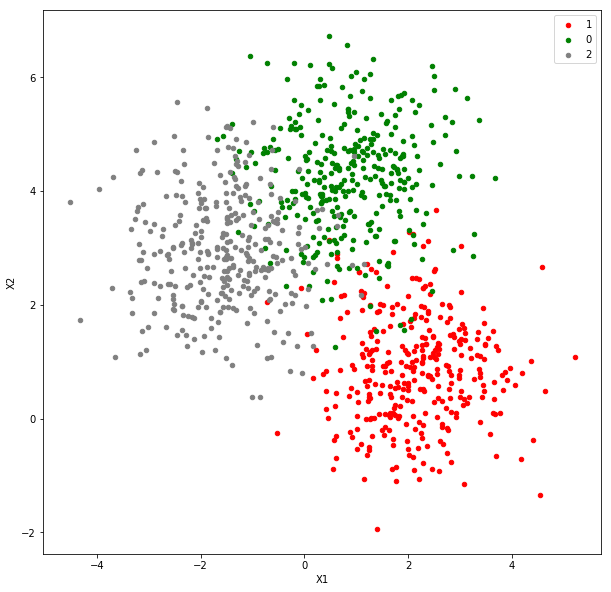

In [285]:
ax = df[y==1].plot(x="X1", y="X2", kind="scatter", label="1", color='r', figsize=(10,10))
df[y==0].plot(x="X1", y="X2", kind="scatter", label="0",color='green', ax=ax)
df[y==2].plot(x="X1", y="X2", kind="scatter", label="2",color='grey', ax=ax)

In [286]:
#Je recupere les "overlapping clusters" avec les kNearestNeighbor
#Si la probailité d'être dans le cluster k est d'au moins 0.1 (à tuner) alors l'observation appartient au cluster k
knn =  KNeighborsClassifier(n_neighbors=30)
knn.fit(X,y)
pred = knn.predict_proba(X)
pred

array([[ 0.06666667,  0.        ,  0.93333333],
       [ 1.        ,  0.        ,  0.        ],
       [ 0.03333333,  0.        ,  0.96666667],
       ..., 
       [ 0.03333333,  0.86666667,  0.1       ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.06666667,  0.93333333,  0.        ]])

In [ ]:
#Load movie data



In [287]:
#Real clusters matrix
def possible_clusters(X):
    I=X.shape[0]
    J=X.shape[1]
    result = np.zeros(X.shape)
    for i in range(I):
        for j in range(J):
            if X[i,j]>0.1:
                result[i,j]=1
    return result
    
#Z = pd.get_dummies(y).as_matrix()
Z=possible_clusters(pred)
Z

array([[ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.]])

## Figure 3 algorithm
###  1. Initialize $\Theta$

In [144]:
#GAUSSIAN CLUSTERS
#mu=multivariate_normal.rvs(mean=np.zeros(2),cov=np.matrix([[1, 0], [0, 1]]),size=3)
#sigma=invwishart.rvs(df=4,size=3,scale=np.matrix([[1, 0], [0, 1]]))

In [288]:
#MULTIVARIATE BERNOULLI
#Initialize Theta matrix K=3 rows, D=2 columns
#D=2
#N=1000
#K=3 fixed for now
theta=np.empty([3,2])
for i in range(0,3):
    for j in range(0,2):
        u=np.random.uniform()
        theta[i,j]=u

In [289]:
theta

array([[ 0.69692405,  0.52859982],
       [ 0.76741886,  0.19372886],
       [ 0.87518606,  0.49965581]])

###  2. Initialize other elements

In [290]:
NumIters = 10
N = df.shape[0]
Z_hat = np.zeros((N,3)) #Matrix of clusters [observations]*[# clusters - takes 1 if belongs to cluster]
PZ_hat = np.zeros((N,3)) #Matrix of cluster probabilities
K=3

In [291]:
#On prend les n premieres observations et on leur donne les bons clusters associés pour entrainer le modele
n=100
for i in range(n):
    Z_hat[i,]=Z[i,]
Z_hat

array([[ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

###  3. Run algorithm

In [292]:
def m_without_i_k(Z, i, k):
    result=0
    for j in range(Z_hat.shape[0]):
        if j!=i:
            result+= Z_hat[j,k]
    return result

for j in range(NumIters):
    for i in range(0,N):
        k_plus = [] #k+ is the number of clusters which data points, excluding i, belong to
        for k_ in range(K):
            if Z_hat[i,k_] == 0:
                k_plus.append(k_)  #for each obs, if proba to belong to cluster k_ is null, add it to k_plus
                                   #for data not in the training set, k_plus will take all possible values in 0...K
        print("k+=",k_plus)
        for k in k_plus:
            if Z_hat[i,k] == 0: #exclude data in the training set for which we already have the true categories
                #z_ik ⇠ zik|z−i,k, xi,theta
                theta_zi=np.zeros(6).reshape([3,2])
                Z_hat[i,k] = 1 #Propose assignment of category k that was null initially
                #Compute theta's of the Bernoulli likelihood function -- EQUATION (7) --
                for d in range(2):
                    num_temp=1
                    den_temp1=1
                    den_temp2=1
                    for k_ in range(K):
                        num_temp=num_temp*(theta[k_,d]**Z[i,k_])
                        den_temp1=den_temp1*((1-theta[k_,d])**Z[i,k_])
                        den_temp2=den_temp2*(theta[k_,d]**Z[i,k_])
                    theta_zi[:,d]=num_temp/(den_temp1+den_temp2)
                #compute bernouilli likelihood (not normalized)
                lh_bern=0
                temp=0
                for k in range(0,K):
                    for d in range(0,2):
                        temp=temp+Z_hat[i,k]*X[i,d]*np.log(theta_zi[k,d]/(1-theta_zi[k,d]))
                lh_bern=np.exp(temp)
                #compute matrix of probas of Z
                PZ_hat[i,k] = (m_without_i_k(Z_hat, i, k)/N)*lh_bern
                Z_hat[i,k] = 0
        #Propose adding new clusters 
        #Accept or reject proposal
        for k in k_plus:
            if Z_hat[i,k] == 0:
                u = np.random.uniform(0,1,1)  #PZ_hat is not normalized to [0,1]
                if u[0]<PZ_hat[i,k]:
                    Z_hat[i,k]=1
                    print(i,k)
    """
    #Resample theta|Z,X using MH proposal
    prob_A=0
    omega=0.5
    for k in range(K):
        #generate proposal theta'(mu' and sigma') based on Beta(omega*theta,omega*(1-theta))
        theta_prime=beta.rvs(omega*theta[k],omega*(1-theta[k]))
        #resample theta
        prob_A=xxx
        #likelihood of x_d | ...
        lh_x=
        #priors beta
        xxx
        """

1 2
5 2
7 2
8 2
9 2
10 2
15 2
17 2
18 2
19 2
21 2
23 2
24 2
28 2
29 2
33 2
35 2
36 2
38 2
39 2
40 2
41 2
43 2
44 2
45 2
46 2
48 2
49 2
50 2
52 2
53 2
54 2
55 2
56 2
59 2
65 2
66 2
67 2
71 2
72 2
74 2
76 2
77 2
82 2
83 2
84 2
85 2
86 2
87 2
88 2
89 2
91 2
92 2
94 2
96 2
98 2
100 2
101 2
102 2
103 2
104 2
105 2
106 2
107 2
108 2
109 2
110 2
111 2
112 2
113 2
114 2
115 2
116 2
117 2
118 2
119 2
120 2
121 2
122 2
123 2
124 2
125 2
126 2
127 2
128 2
129 2
130 2
131 2
132 2
133 2
134 2
135 2
136 2
137 2
138 2
139 2
140 2
141 2
142 2
143 2
144 2
145 2
146 2
147 2
148 2
149 2
150 2
151 2
152 2
153 2
154 2
155 2
156 2
157 2
158 2
159 2
160 2
161 2
162 2
163 2
164 2
165 2
166 2
167 2
168 2
169 2
170 2
171 2
172 2
173 2
174 2
175 2
176 2
177 2
178 2
179 2
180 2
181 2
182 2
183 2
184 2
185 2
186 2
187 2
188 2
189 2
190 2
191 2
192 2
193 2
194 2
195 2
196 2
197 2
198 2
199 2
200 2
201 2
202 2
203 2
204 2
205 2
206 2
207 2
208 2
209 2
210 2
211 2
212 2
213 2
214 2
215 2
216 2
217 2
218 2
219 2
220 2

In [296]:
Z_hat[0:10,:]

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]])

In [294]:
U = np.dot(Z,Z.T)
print(U)
U_hat = np.dot(Z_hat,Z_hat.T)
print(U_hat)

[[ 1.  0.  1. ...,  0.  1.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 1.  0.  1. ...,  0.  1.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  1.]
 [ 1.  0.  1. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  1.  0.  1.]]
[[ 3.  3.  3. ...,  3.  3.  3.]
 [ 3.  3.  3. ...,  3.  3.  3.]
 [ 3.  3.  3. ...,  3.  3.  3.]
 ..., 
 [ 3.  3.  3. ...,  3.  3.  3.]
 [ 3.  3.  3. ...,  3.  3.  3.]
 [ 3.  3.  3. ...,  3.  3.  3.]]


### 4. $U$ and $\hat{U}$ comparison

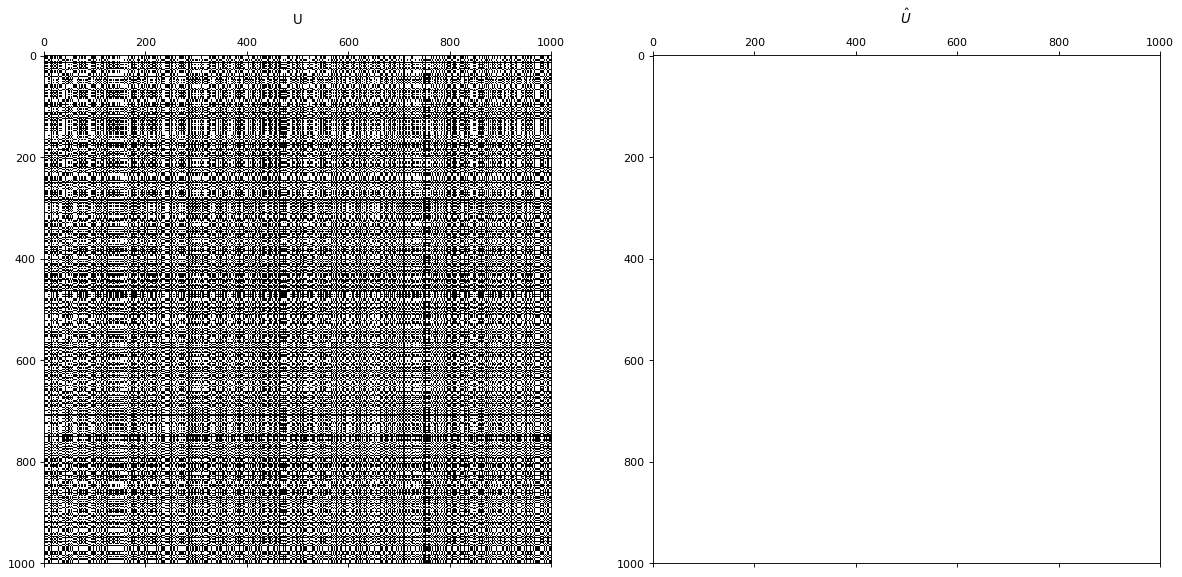

In [259]:
fig = figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('U')
ax2.title.set_text('$\hat{U}$')

ax1.spy(U)
ax2.spy(U_hat)

show()